패키지 설치 및 불러오기

In [ ]:

# 1. 라이브러리 임포트

%pip install yfinance  # (Colab 등에서 필요 시)
%pip install tensorflow
%pip install matplot
import yfinance as yf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import random



1. 단순 분할(80/20) | Sentiment값 0으로 고정


In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

# RMSE 계산 함수 정의
def calculate_rmse(Y_true, Y_pred):
    return np.sqrt(mean_squared_error(Y_true, Y_pred))

# MAE 계산 함수 정의 (sklearn 사용)
def calculate_mae(Y_true, Y_pred):
    return mean_absolute_error(Y_true, Y_pred)

# MAPE 계산 함수 정의
def calculate_mape(Y_true, Y_pred):
    y_true = np.array(Y_true)
    y_pred = np.array(Y_pred)
    # 실제값이 0이면 작은 값으로 대체하여 계산
    y_true_adj = np.where(y_true == 0, 0.001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# 결과 저장을 위한 빈 딕셔너리 초기화
results = {
    'Company': [],
    'RMSE (no sentiment)': [],
    'RMSE (with sentiment)': [],
}

# 기존 결과 파일이 있는지 확인하고, 있다면 불러오기
results_file_path = "/content/drive/MyDrive/LSTM_results.csv"
if os.path.isfile(results_file_path):
    existing_results = pd.read_csv(results_file_path)
else:
    existing_results = None

# (예시) 여러 종목에 대한 Ticker를 담은 딕셔너리
stock_dict = {
    "Apple": "AAPL",
    "Microsoft": "MSFT"
}

# 예시: 2020-01-01 ~ 2023-01-01 구간
start_date = "2024-01-01"
end_date   = "2025-01-01"

#----------------------------------------------
# LSTM 윈도우 구성 함수
#----------------------------------------------
def create_dataset(dataset, seq_size):
    X, Y = [], []
    for i in range(len(dataset) - seq_size - 1):
        X.append(dataset[i:(i + seq_size)])
        Y.append(dataset[i + seq_size])
    return np.array(X), np.array(Y)

#----------------------------------------------
# 각 종목별로 학습/예측 수행
#----------------------------------------------
for company_name, company_code in stock_dict.items():
    #==============================================
    # 1) "No Sentiment": 야후 파이낸스 데이터만
    #==============================================
    df_no_sentiment = yf.download(company_code, start=start_date, end=end_date, progress=False)
    df_no_sentiment.reset_index(inplace=True)
    df_no_sentiment = df_no_sentiment[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df_no_sentiment.fillna(method='ffill', inplace=True)

    #==============================================
    # 2) "With Sentiment": 0으로 고정된 컬럼 추가
    #==============================================
    df_with_sentiment = df_no_sentiment.copy()
    df_with_sentiment["Sentiment"] = 0.0

    # 결과를 저장할 리스트
    rmse_results_no_sentiment = []
    rmse_results_with_sentiment = []

    seq_size = 10  # 시퀀스 길이

    #----------------------------------------------------------------
    # (A) No Sentiment 케이스
    #----------------------------------------------------------------
    # date 제외 -> ['Open','High','Low','Close','Volume']
    columns_no_sentiment = df_no_sentiment.columns[1:]
    data_no_sentiment = df_no_sentiment.iloc[:, 1:].values.astype(float)
    scaler_no_sentiment = MinMaxScaler(feature_range=(0, 1))
    scaled_data_no_sentiment = scaler_no_sentiment.fit_transform(data_no_sentiment)
    X, Y_data = create_dataset(scaled_data_no_sentiment, seq_size)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    Y_train, Y_test = Y_data[:train_size], Y_data[train_size:]

    model = Sequential()
    model.add(LSTM(50, return_sequences=True,
                   input_shape=(seq_size, len(columns_no_sentiment)),
                   kernel_regularizer=l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, kernel_regularizer=l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(len(columns_no_sentiment)))
    model.compile(optimizer='adam', loss='mean_squared_error')

    def scheduler(epoch, lr):
        return lr * 0.99
    callback = LearningRateScheduler(scheduler)

    model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
              epochs=50, batch_size=32, callbacks=[callback], verbose=1)

    predictions = model.predict(X_test)
    rmse_no_sent = calculate_rmse(Y_test, predictions)
    mae_no_sent = calculate_mae(Y_test, predictions)
    mape_no_sent = calculate_mape(Y_test, predictions)
    rmse_results_no_sentiment.append(rmse_no_sent)

    print(f"\n{company_name} (No Sentiment) Metrics:")
    print("  RMSE: {:.4f}".format(rmse_no_sent))
    print("  MAE: {:.4f}".format(mae_no_sent))
    print("  MAPE: {:.2f}%".format(mape_no_sent))
    # 개별 샘플 오차 확인 (첫 5개 샘플)
    for i in range(5):
        error = Y_test[i] - predictions[i]
        print(f"  Sample {i+1} - Actual: {Y_test[i]}, Predicted: {predictions[i]}, Error: {error}")
    # ±5% 오차 내 정확도 계산
    threshold = 0.05
    relative_errors = np.abs((Y_test - predictions) / np.where(Y_test==0, 0.001, Y_test))
    accurate_ratio = np.mean(relative_errors < threshold)
    print("  Accuracy (within ±5% error): {:.2f}%".format(accurate_ratio * 100))

    #----------------------------------------------------------------
    # (B) With Sentiment 케이스 (Sentiment=0)
    #----------------------------------------------------------------
    # date 제외 -> ['Open','High','Low','Close','Volume','Sentiment']
    columns_with_sentiment = df_with_sentiment.columns[1:]
    data_with_sentiment = df_with_sentiment.iloc[:, 1:].values.astype(float)
    scaler_with_sentiment = MinMaxScaler(feature_range=(0, 1))
    scaled_data_with_sentiment = scaler_with_sentiment.fit_transform(data_with_sentiment)
    X_s, Y_data_s = create_dataset(scaled_data_with_sentiment, seq_size)

    train_size_s = int(len(X_s) * 0.8)
    X_train_s, X_test_s = X_s[:train_size_s], X_s[train_size_s:]
    Y_train_s, Y_test_s = Y_data_s[:train_size_s], Y_data_s[train_size_s:]

    model_s = Sequential()
    model_s.add(LSTM(50, return_sequences=True,
                     input_shape=(seq_size, len(columns_with_sentiment)),
                     kernel_regularizer=l2(1e-5)))
    model_s.add(Dropout(0.2))
    model_s.add(LSTM(50, kernel_regularizer=l2(1e-5)))
    model_s.add(Dropout(0.2))
    model_s.add(Dense(len(columns_with_sentiment)))
    model_s.compile(optimizer='adam', loss='mean_squared_error')

    model_s.fit(X_train_s, Y_train_s, validation_data=(X_test_s, Y_test_s),
                epochs=50, batch_size=32, callbacks=[callback], verbose=1)

    predictions_s = model_s.predict(X_test_s)
    rmse_with_sent = calculate_rmse(Y_test_s, predictions_s)
    mae_with_sent = calculate_mae(Y_test_s, predictions_s)
    mape_with_sent = calculate_mape(Y_test_s, predictions_s)
    rmse_results_with_sentiment.append(rmse_with_sent)

    print(f"\n{company_name} (With Sentiment=0) Metrics:")
    print("  RMSE: {:.4f}".format(rmse_with_sent))
    print("  MAE: {:.4f}".format(mae_with_sent))
    print("  MAPE: {:.2f}%".format(mape_with_sent))
    # 개별 샘플 오차 확인 (첫 5개 샘플)
    for i in range(5):
        error = Y_test_s[i] - predictions_s[i]
        print(f"  Sample {i+1} - Actual: {Y_test_s[i]}, Predicted: {predictions_s[i]}, Error: {error}")
    # ±5% 오차 내 정확도 계산
    relative_errors_s = np.abs((Y_test_s - predictions_s) / np.where(Y_test_s==0, 0.001, Y_test_s))
    accurate_ratio_s = np.mean(relative_errors_s < threshold)
    print("  Accuracy (within ±5% error): {:.2f}%".format(accurate_ratio_s * 100))

    #----------------------------------------------------------------
    # 결과 출력 및 저장
    #----------------------------------------------------------------
    print(f"\n{company_name} (No Sentiment) RMSE: {rmse_results_no_sentiment}")
    print(f"{company_name} (With Sentiment=0) RMSE: {rmse_results_with_sentiment}")

    results['Company'].append(company_code)
    results['RMSE (no sentiment)'].append(rmse_results_no_sentiment)
    results['RMSE (with sentiment)'].append(rmse_results_with_sentiment)

df_results = pd.DataFrame(results)
print("\nFinal Results:")
print(df_results)

Epoch 1/50


/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/544065624.py:74: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_no_sentiment.fillna(method='ffill', inplace=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.1501 - val_loss: 0.2399 - learning_rate: 9.9000e-04
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0731 - val_loss: 0.0532 - learning_rate: 9.8010e-04
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0252 - val_loss: 0.0096 - learning_rate: 9.7030e-04
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0189 - val_loss: 0.0223 - learning_rate: 9.6060e-04
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0161 - val_loss: 0.0165 - learning_rate: 9.5099e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0142 - val_loss: 0.0128 - learning_rate: 9.4148e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0148 - val_loss: 0.0129 - learning_rate: 9.3207e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0126 - val_loss: 0.0088 - learning_rate: 9.2274e-04
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119 - val_loss: 0.0068 - learning_rate: 9.1352e-04
Epoch 10/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1091 - val_loss: 0.1232 - learning_rate: 9.9000e-04
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0316 - val_loss: 0.0085 - learning_rate: 9.8010e-04
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0226 - val_loss: 0.0096 - learning_rate: 9.7030e-04
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0154 - val_loss: 0.0330 - learning_rate: 9.6060e-04
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0179 - val_loss: 0.0242 - learning_rate: 9.5099e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0114 - val_loss: 0.0081 - learning_rate: 9.4148e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0107 - val_loss: 0.0068 - learning_rate: 9.3207e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0106 - val_loss: 0.0104 - learning_rate: 9.2274e-04
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0118 - val_loss: 0.0087 - learning_rate: 9.1352e-04
Epoch 10/50


/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_13271/544065624.py:74: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_no_sentiment.fillna(method='ffill', inplace=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.1990 - val_loss: 0.1086 - learning_rate: 9.9000e-04
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0603 - val_loss: 0.0230 - learning_rate: 9.8010e-04
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0326 - val_loss: 0.0173 - learning_rate: 9.7030e-04
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0275 - val_loss: 0.0257 - learning_rate: 9.6060e-04
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0242 - val_loss: 0.0211 - learning_rate: 9.5099e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0225 - val_loss: 0.0163 - learning_rate: 9.4148e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0212 - val_loss: 0.0160 - learning_rate: 9.3207e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0204 - val_loss: 0.0153 - learning_rate: 9.2274e-04
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0197 - val_loss: 0.0156 - learning_rate: 9.1352e-04
Epoch 10/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.1806 - val_loss: 0.1116 - learning_rate: 9.9000e-04
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0625 - val_loss: 0.0178 - learning_rate: 9.8010e-04
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0308 - val_loss: 0.0168 - learning_rate: 9.7030e-04
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0269 - val_loss: 0.0214 - learning_rate: 9.6060e-04
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0231 - val_loss: 0.0189 - learning_rate: 9.5099e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0192 - val_loss: 0.0146 - learning_rate: 9.4148e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0196 - val_loss: 0.0123 - learning_rate: 9.3207e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0184 - val_loss: 0.0153 - learning_rate: 9.2274e-04
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162 - val_loss: 0.0144 - learning_rate: 9.1352e-04
Epoch 10/50
6/6 ━━

# Rolling Window | LSTM(50) → Dropout → LSTM(50) → Dropout → Dense(len(columns))

In [ ]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --------------------------------------------
# 지표 계산 함수
# --------------------------------------------
def calculate_rmse(Y_true, Y_pred):
    return np.sqrt(mean_squared_error(Y_true, Y_pred))

def calculate_mae(Y_true, Y_pred):
    return mean_absolute_error(Y_true, Y_pred)

def calculate_mape(Y_true, Y_pred):
    y_true = np.array(Y_true)
    y_pred = np.array(Y_pred)
    y_true_adj = np.where(y_true == 0, 0.001, y_true)  # 0으로 나누는 것 방지
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# --------------------------------------------
# 시계열 데이터 구성 (종가만 예측)
# --------------------------------------------
def create_dataset(dataset, seq_size, target_index):
    X, Y = [], []
    for i in range(len(dataset) - seq_size - 1):
        X.append(dataset[i:(i + seq_size)])
        Y.append(dataset[i + seq_size, target_index])  # 종가만 예측
    return np.array(X), np.array(Y)

# --------------------------------------------
# 롤링 윈도우 LSTM 학습/예측
# --------------------------------------------
def rolling_window_evaluation(X, Y, seq_size, input_dim,
                              epochs=50, batch_size=32,
                              train_window=500, test_window=100):
    total_samples = len(X)
    metrics_list = []

    for start in range(0, total_samples - train_window - test_window + 1, test_window):
        X_train = X[start: start + train_window]
        Y_train = Y[start: start + train_window]
        X_test = X[start + train_window: start + train_window + test_window]
        Y_test = Y[start + train_window: start + train_window + test_window]

        model = Sequential()
        model.add(LSTM(50, return_sequences=True,
                       input_shape=(seq_size, input_dim),
                       kernel_regularizer=l2(1e-5)))
        model.add(Dropout(0.2))
        model.add(LSTM(50, kernel_regularizer=l2(1e-5)))
        model.add(Dropout(0.2))
        model.add(Dense(1))  # 종가 하나만 예측
        model.compile(optimizer='adam', loss='mean_squared_error')

        def scheduler(epoch, lr):
            return lr * 0.99
        callback = LearningRateScheduler(scheduler)

        model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=epochs, batch_size=batch_size, callbacks=[callback], verbose=0)

        predictions = model.predict(X_test)
        rmse = calculate_rmse(Y_test, predictions)
        mae = calculate_mae(Y_test, predictions)
        mape = calculate_mape(Y_test, predictions)

        metrics_list.append((rmse, mae, mape))

    return metrics_list

# --------------------------------------------
# 설정
# --------------------------------------------
results = {
    'Company': [],
    'RMSE (no sentiment)': [],
    'RMSE (with sentiment)': [],
}

results_file_path = "LSTM_results.csv"
stock_dict = {
    "Apple": "AAPL",
    "Microsoft": "MSFT"
}
start_date = "2020-01-01"
end_date   = "2025-01-01"
seq_size = 10
target_index = 3  # 'Close' 컬럼 위치

# --------------------------------------------
# 종목별 학습 루프
# --------------------------------------------
for company_name, company_code in stock_dict.items():
    print(f"\n📈 Processing {company_name} ({company_code})...")

    # 1) 야후 파이낸스 데이터 수집
    df = yf.download(company_code, start=start_date, end=end_date, progress=False)
    df.reset_index(inplace=True)
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df.ffill(inplace=True)

    # 2) 감성 분석 없는 케이스
    df_no_sentiment = df.copy()
    cols_no = df_no_sentiment.columns[1:]
    data_no = df_no_sentiment[cols_no].values.astype(float)
    scaler_no = MinMaxScaler()
    scaled_no = scaler_no.fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size, target_index)

    metrics_no = rolling_window_evaluation(X_no, Y_no, seq_size, len(cols_no),
                                           epochs=50, batch_size=32,
                                           train_window=500, test_window=100)

    avg_rmse_no = np.mean([m[0] for m in metrics_no])
    avg_mae_no  = np.mean([m[1] for m in metrics_no])
    avg_mape_no = np.mean([m[2] for m in metrics_no])

    print(f"{company_name} (No Sentiment) Metrics:")
    print(f"  ✅ RMSE:  {avg_rmse_no:.4f}")
    print(f"  ✅ MAE:   {avg_mae_no:.4f}")
    print(f"  ✅ MAPE:  {avg_mape_no:.2f}%")

    # 3) 감성 점수 포함 (0으로 초기화)
    df_with_sentiment = df.copy()
    df_with_sentiment["Sentiment"] = 0.0
    cols_with = df_with_sentiment.columns[1:]
    data_with = df_with_sentiment[cols_with].values.astype(float)
    scaler_with = MinMaxScaler()
    scaled_with = scaler_with.fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size, target_index)

    metrics_with = rolling_window_evaluation(X_with, Y_with, seq_size, len(cols_with),
                                             epochs=50, batch_size=32,
                                             train_window=500, test_window=100)

    avg_rmse_with = np.mean([m[0] for m in metrics_with])
    avg_mae_with  = np.mean([m[1] for m in metrics_with])
    avg_mape_with = np.mean([m[2] for m in metrics_with])

    print(f"{company_name} (With Sentiment = 0) Metrics:")
    print(f"  ✅ RMSE:  {avg_rmse_with:.4f}")
    print(f"  ✅ MAE:   {avg_mae_with:.4f}")
    print(f"  ✅ MAPE:  {avg_mape_with:.2f}%")

    # 결과 저장
    results['Company'].append(company_code)
    results['RMSE (no sentiment)'].append(avg_rmse_no)
    results['RMSE (with sentiment)'].append(avg_rmse_with)

# --------------------------------------------
# 최종 결과 저장
# --------------------------------------------
df_results = pd.DataFrame(results)
df_results.to_csv(results_file_path, index=False)
print("\n📊 Final Results:")
print(df_results)

## 기본 LSTM + Rolling Window (저장부분, 평가지표 추가) 코드 수정

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

📈 Apple (AAPL)
[No Sentiment]  RMSE: 0.0472, MAE: 0.0397, MAPE: 14.62%, Accuracy: 23.95%
[With Sentiment] RMSE: 0.0531, MAE: 0.0435, MAPE: 14.51%, Accuracy: 23.46%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

📈 Microsoft (MSFT)
[No Sentiment]  RMSE: 0.0409, MAE: 0.0324, MAPE: 7.43%, Accuracy: 41.33%
[With Sentiment] RMSE: 0.0374, MAE: 0.0300, MAPE: 7.27%, Accuracy: 42.75%


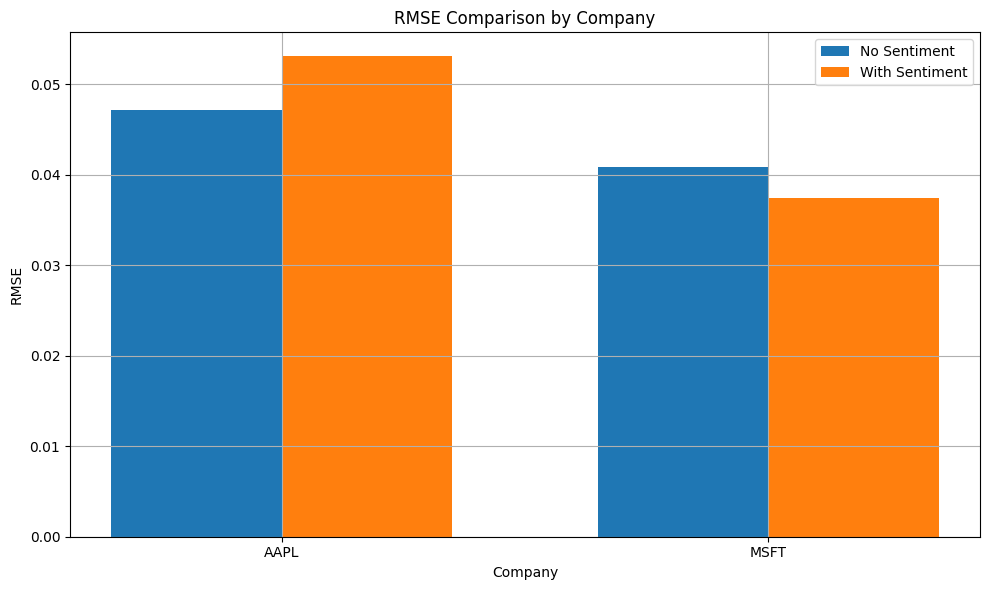

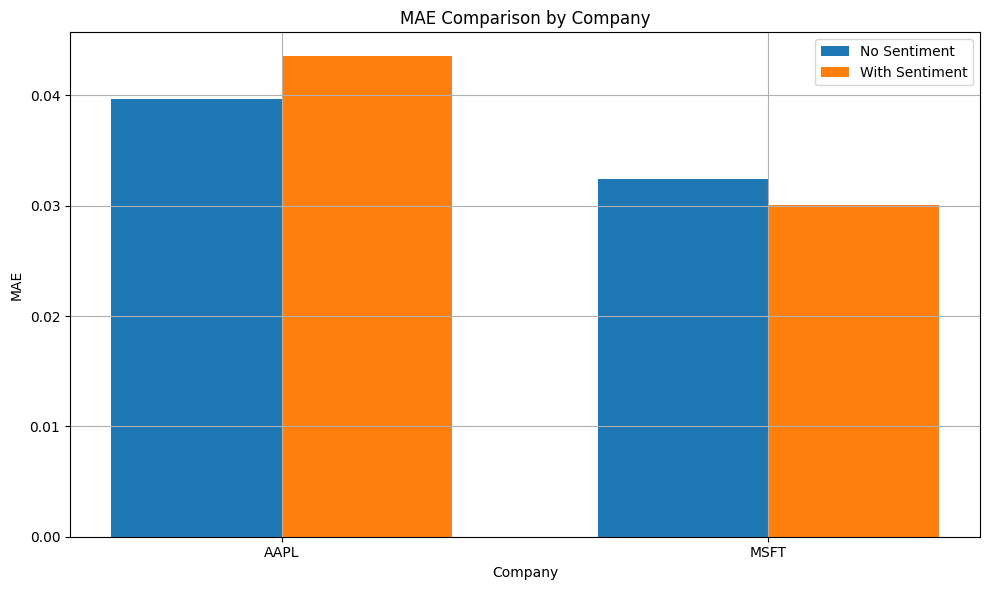

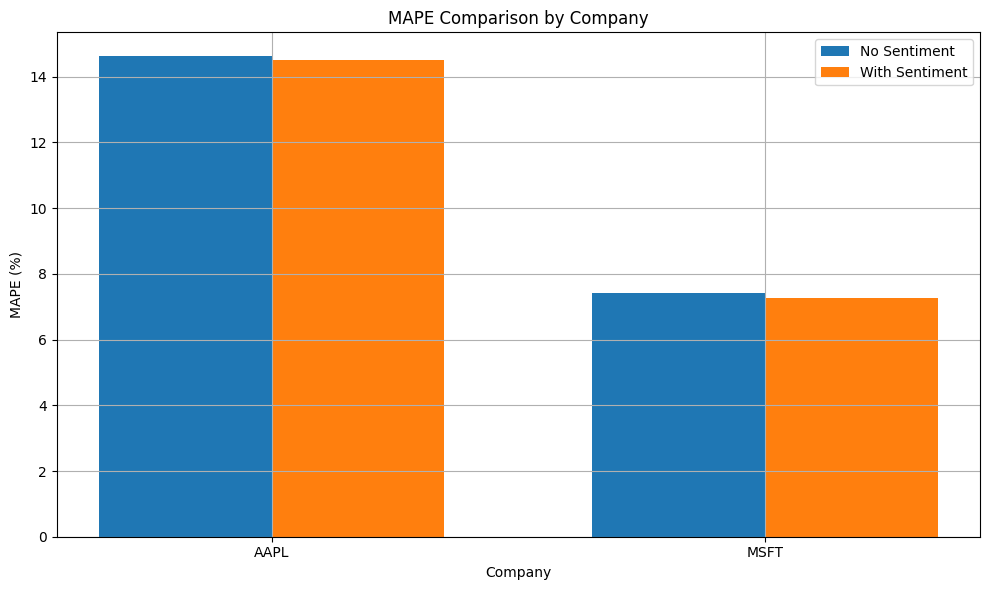

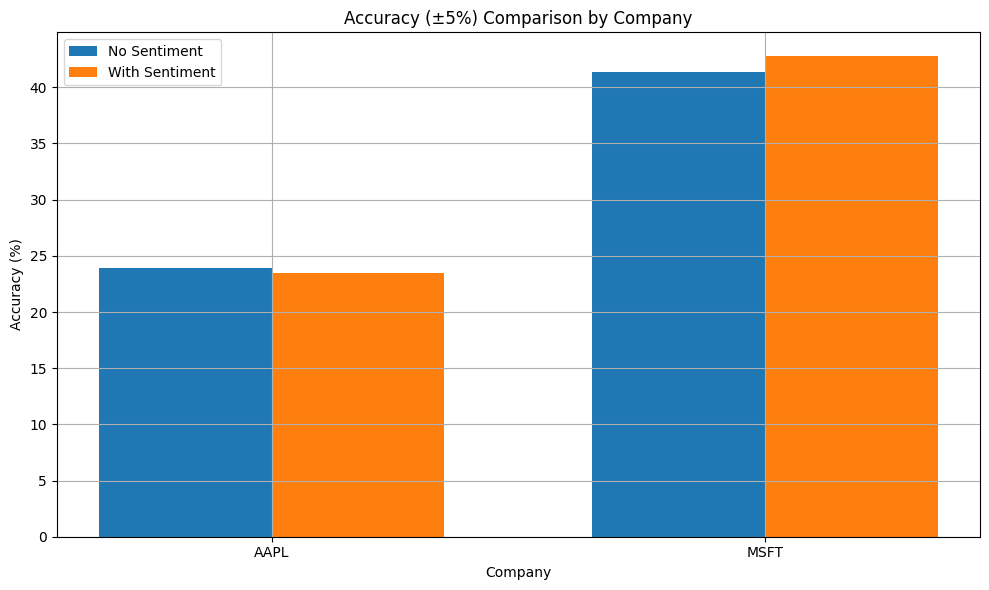

In [8]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------------------
# 폴더 생성 및 설정
# ------------------------------
os.makedirs("results", exist_ok=True)
results_file_path = "./results/LSTM_results.csv"

# ------------------------------
# 지표 계산 함수
# ------------------------------
def calculate_rmse(Y_true, Y_pred):
    return np.sqrt(mean_squared_error(Y_true, Y_pred))

def calculate_mae(Y_true, Y_pred):
    return mean_absolute_error(Y_true, Y_pred)

def calculate_mape(Y_true, Y_pred):
    y_true = np.array(Y_true)
    y_pred = np.array(Y_pred)
    y_true_adj = np.where(y_true == 0, 0.001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# ------------------------------
# 데이터셋 구성 함수
# ------------------------------
def create_dataset(dataset, seq_size, target_index):
    X, Y = [], []
    for i in range(len(dataset) - seq_size - 1):
        X.append(dataset[i:(i + seq_size)])
        Y.append(dataset[i + seq_size, target_index])
    return np.array(X), np.array(Y)

# ------------------------------
# 롤링 윈도우 평가 함수
# ------------------------------
def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=500, test_window=100, threshold=0.05):
    total_samples = len(X)
    metrics_list = []

    for start in range(0, total_samples - train_window - test_window + 1, test_window):
        X_train = X[start: start + train_window]
        Y_train = Y[start: start + train_window]
        X_test  = X[start + train_window: start + train_window + test_window]
        Y_test  = Y[start + train_window: start + train_window + test_window]

        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        def scheduler(epoch, lr):
            return lr * 0.99
        callback = LearningRateScheduler(scheduler)

        model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=epochs, batch_size=batch_size, callbacks=[callback], verbose=0)

        predictions = model.predict(X_test)
        rmse = calculate_rmse(Y_test, predictions)
        mae = calculate_mae(Y_test, predictions)
        mape = calculate_mape(Y_test, predictions)
        relative_errors = np.abs((Y_test - predictions) / np.where(Y_test == 0, 0.001, Y_test))
        accuracy = np.mean(relative_errors < threshold) * 100

        metrics_list.append((rmse, mae, mape, accuracy))

    return metrics_list

# ------------------------------
# 학습 및 평가 실행
# ------------------------------
results = {
    'Company': [],
    'RMSE (no sentiment)': [],
    'MAE (no sentiment)': [],
    'MAPE (no sentiment)': [],
    'Accuracy (no sentiment)': [],
    'RMSE (with sentiment)': [],
    'MAE (with sentiment)': [],
    'MAPE (with sentiment)': [],
    'Accuracy (with sentiment)': [],
}

stock_dict = {
    "Apple": "AAPL",
    "Microsoft": "MSFT"
}
start_date = "2022-01-01"
end_date = "2025-01-01"
seq_size = 10
target_index = 3

for company_name, ticker in stock_dict.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    df.reset_index(inplace=True)
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df.ffill(inplace=True)

    df_with_sentiment = df.copy()
    df_with_sentiment['Sentiment'] = 0.0

    # No Sentiment
    cols_no = df.columns[1:]
    data_no = df[cols_no].values.astype(float)
    scaler_no = MinMaxScaler()
    scaled_no = scaler_no.fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size, target_index)

    metrics_no = rolling_window_evaluation(X_no, Y_no, seq_size, cols_no)
    if not metrics_no:
        continue

    avg_rmse_no = np.mean([m[0] for m in metrics_no])
    avg_mae_no = np.mean([m[1] for m in metrics_no])
    avg_mape_no = np.mean([m[2] for m in metrics_no])
    avg_acc_no = np.mean([m[3] for m in metrics_no])

    # With Sentiment
    cols_with = df_with_sentiment.columns[1:]
    data_with = df_with_sentiment[cols_with].values.astype(float)
    scaler_with = MinMaxScaler()
    scaled_with = scaler_with.fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size, target_index)

    metrics_with = rolling_window_evaluation(X_with, Y_with, seq_size, cols_with)
    if not metrics_with:
        continue

    avg_rmse_with = np.mean([m[0] for m in metrics_with])
    avg_mae_with = np.mean([m[1] for m in metrics_with])
    avg_mape_with = np.mean([m[2] for m in metrics_with])
    avg_acc_with = np.mean([m[3] for m in metrics_with])

    print(f"\n📈 {company_name} ({ticker})")
    print(f"[No Sentiment]  RMSE: {avg_rmse_no:.4f}, MAE: {avg_mae_no:.4f}, MAPE: {avg_mape_no:.2f}%, Accuracy: {avg_acc_no:.2f}%")
    print(f"[With Sentiment] RMSE: {avg_rmse_with:.4f}, MAE: {avg_mae_with:.4f}, MAPE: {avg_mape_with:.2f}%, Accuracy: {avg_acc_with:.2f}%")

    results['Company'].append(ticker)
    results['RMSE (no sentiment)'].append(avg_rmse_no)
    results['MAE (no sentiment)'].append(avg_mae_no)
    results['MAPE (no sentiment)'].append(avg_mape_no)
    results['Accuracy (no sentiment)'].append(avg_acc_no)
    results['RMSE (with sentiment)'].append(avg_rmse_with)
    results['MAE (with sentiment)'].append(avg_mae_with)
    results['MAPE (with sentiment)'].append(avg_mape_with)
    results['Accuracy (with sentiment)'].append(avg_acc_with)

# 결과 저장
df_results = pd.DataFrame(results)
df_results.to_csv(results_file_path, index=False)

# ------------------------------
# 시각화 함수
# ------------------------------
def plot_metric(metric_name, title, ylabel):
    plt.figure(figsize=(10, 6))
    x = df_results['Company']
    no_sentiment = df_results[f'{metric_name} (no sentiment)']
    with_sentiment = df_results[f'{metric_name} (with sentiment)']

    bar_width = 0.35
    index = range(len(x))

    plt.bar(index, no_sentiment, bar_width, label='No Sentiment')
    plt.bar([i + bar_width for i in index], with_sentiment, bar_width, label='With Sentiment')

    plt.xlabel('Company')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks([i + bar_width / 2 for i in index], x)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------
# 시각화 실행
# ------------------------------
plot_metric("RMSE", "RMSE Comparison by Company", "RMSE")
plot_metric("MAE", "MAE Comparison by Company", "MAE")
plot_metric("MAPE", "MAPE Comparison by Company", "MAPE (%)")
plot_metric("Accuracy", "Accuracy (±5%) Comparison by Company", "Accuracy (%)")


## 코드 2 : 기본 LSTM + 시각화

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━

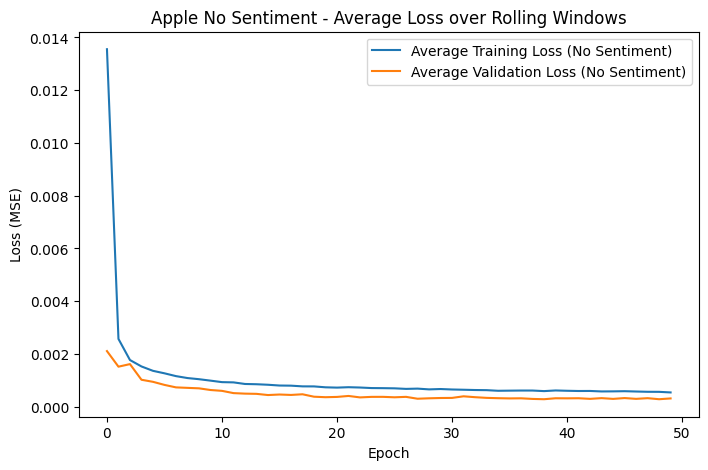

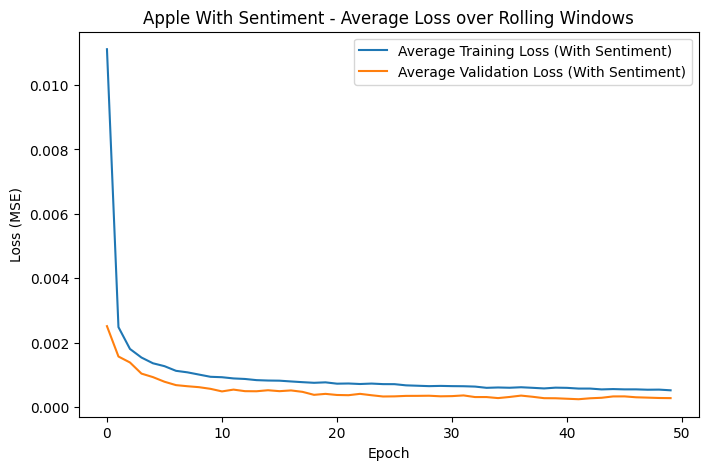

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━

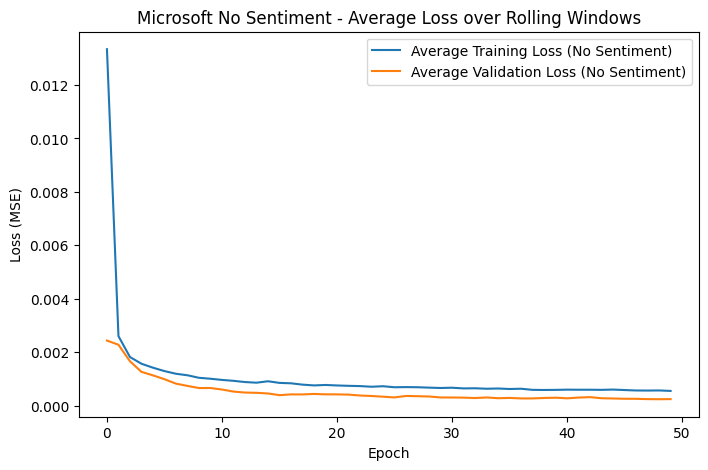

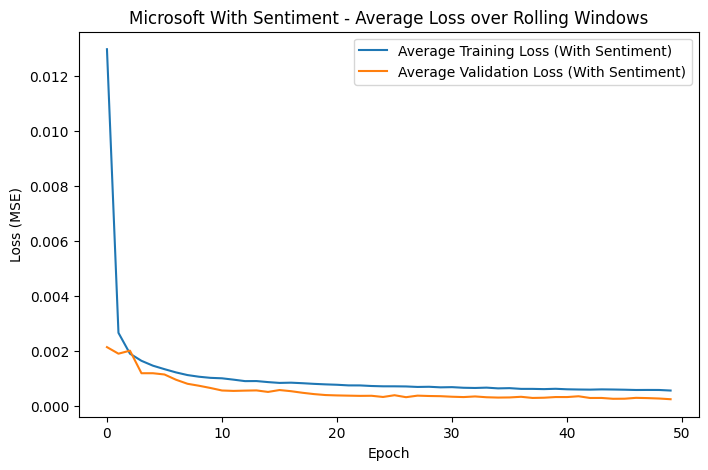


Final Results:
  Company  RMSE (no sentiment)  Accuracy (no sentiment)  \
0    AAPL             0.007627                35.660877   
1    MSFT             0.006841                33.923158   

   RMSE (with sentiment)  Accuracy (with sentiment)  
0               0.007263                  33.922281  
1               0.006642                  33.432807  


In [9]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

# 결과 저장할 디렉토리 생성 (없으면 생성)
os.makedirs("results", exist_ok=True)

# RMSE, MAE, MAPE 계산 함수 정의
def calculate_rmse(Y_true, Y_pred):
    return np.sqrt(mean_squared_error(Y_true, Y_pred))

def calculate_mae(Y_true, Y_pred):
    return mean_absolute_error(Y_true, Y_pred)

def calculate_mape(Y_true, Y_pred):
    y_true = np.array(Y_true)
    y_pred = np.array(Y_pred)
    y_true_adj = np.where(y_true == 0, 0.001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# 결과 저장을 위한 빈 딕셔너리 초기화
results = {
    'Company': [],
    'RMSE (no sentiment)': [],
    'Accuracy (no sentiment)': [],
    'RMSE (with sentiment)': [],
    'Accuracy (with sentiment)': [],
}

results_file_path = "./results/LSTM_results.csv"
if os.path.isfile(results_file_path):
    existing_results = pd.read_csv(results_file_path)
else:
    existing_results = None

# 여러 종목에 대한 Ticker
stock_dict = {
    "Apple": "AAPL",
    "Microsoft": "MSFT"
}

# 데이터 기간 설정
start_date = "2000-01-01"
end_date   = "2025-01-01"

#----------------------------------------------
# LSTM 윈도우 구성 함수 (target_index를 이용하여 종가만 예측)
#----------------------------------------------
def create_dataset(dataset, seq_size, target_index):
    X, Y = [], []
    for i in range(len(dataset) - seq_size - 1):
        X.append(dataset[i:(i + seq_size)])
        Y.append(dataset[i + seq_size, target_index])
    return np.array(X), np.array(Y)

#----------------------------------------------
# 롤링 윈도우 학습/검증 함수 (제안된 모델 적용)
#----------------------------------------------
def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=500, test_window=100, threshold=0.05):
    total_samples = len(X)
    metrics_list = []  # 각 윈도우의 (rmse, mae, mape, accuracy)
    history_list = []  # 각 윈도우의 history.history (loss, val_loss)
    
    for start in range(0, total_samples - train_window - test_window + 1, test_window):
        X_train = X[start: start + train_window]
        Y_train = Y[start: start + train_window]
        X_test  = X[start + train_window: start + train_window + test_window]
        Y_test  = Y[start + train_window: start + train_window + test_window]
        
        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        def scheduler(epoch, lr):
            return lr * 0.99
        callback = LearningRateScheduler(scheduler)
        
        history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=epochs, batch_size=batch_size, callbacks=[callback], verbose=0)
        
        history_list.append(history.history)
        
        predictions = model.predict(X_test)
        rmse_val = calculate_rmse(Y_test, predictions)
        mae_val  = calculate_mae(Y_test, predictions)
        mape_val = calculate_mape(Y_test, predictions)
        relative_errors = np.abs((Y_test - predictions) / np.where(Y_test==0, 0.001, Y_test))
        accuracy = np.mean(relative_errors < threshold) * 100
        metrics_list.append((rmse_val, mae_val, mape_val, accuracy))
    return metrics_list, history_list

#----------------------------------------------
# 각 종목별로 Rolling Window 방식으로 학습/예측 수행 (종가 예측용)
#----------------------------------------------
# 예측 대상: 종가 ("Close") → No Sentiment에서는 ['Open','High','Low','Close','Volume']에서 Close는 인덱스 3  
# With Sentiment의 경우에도 동일하게, ['Open','High','Low','Close','Volume','Sentiment']에서 Close는 인덱스 3
target_index = 3

for company_name, company_code in stock_dict.items():
    # 1) "No Sentiment": 야후 파이낸스 데이터만
    df_no_sentiment = yf.download(company_code, start=start_date, end=end_date, progress=False)
    df_no_sentiment.reset_index(inplace=True)
    df_no_sentiment = df_no_sentiment[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df_no_sentiment.ffill(inplace=True)
    
    # 2) "With Sentiment": 0으로 고정된 컬럼 추가
    df_with_sentiment = df_no_sentiment.copy()
    df_with_sentiment["Sentiment"] = 0.0

    seq_size = 10

    # --- No Sentiment 케이스 ---
    columns_no_sentiment = df_no_sentiment.columns[1:]  # ['Open','High','Low','Close','Volume']
    data_no_sentiment = df_no_sentiment.iloc[:, 1:].values.astype(float)
    scaler_no_sentiment = MinMaxScaler(feature_range=(0, 1))
    scaled_data_no_sentiment = scaler_no_sentiment.fit_transform(data_no_sentiment)
    X_no, Y_no = create_dataset(scaled_data_no_sentiment, seq_size, target_index)
    
    metrics_no, history_no = rolling_window_evaluation(X_no, Y_no, seq_size, columns_no_sentiment,
                                           epochs=50, batch_size=32,
                                           train_window=500, test_window=100, threshold=0.05)
    avg_rmse_no = np.mean([m[0] for m in metrics_no])
    avg_accuracy_no = np.mean([m[3] for m in metrics_no])
    
    print(f"\n{company_name} (No Sentiment) Rolling Window Metrics (종가 예측):")
    print("  Average RMSE: {:.4f}".format(avg_rmse_no))
    print("  Average Accuracy (±5% error): {:.2f}%".format(avg_accuracy_no))
    
    # --- With Sentiment 케이스 ---
    columns_with_sentiment = df_with_sentiment.columns[1:]  # ['Open','High','Low','Close','Volume','Sentiment']
    data_with_sentiment = df_with_sentiment.iloc[:, 1:].values.astype(float)
    scaler_with_sentiment = MinMaxScaler(feature_range=(0, 1))
    scaled_data_with_sentiment = scaler_with_sentiment.fit_transform(data_with_sentiment)
    X_with, Y_with = create_dataset(scaled_data_with_sentiment, seq_size, target_index)
    
    metrics_with, history_with = rolling_window_evaluation(X_with, Y_with, seq_size, columns_with_sentiment,
                                             epochs=50, batch_size=32,
                                             train_window=500, test_window=100, threshold=0.05)
    avg_rmse_with = np.mean([m[0] for m in metrics_with])
    avg_accuracy_with = np.mean([m[3] for m in metrics_with])
    
    print(f"\n{company_name} (With Sentiment=0) Rolling Window Metrics (종가 예측):")
    print("  Average RMSE: {:.4f}".format(avg_rmse_with))
    print("  Average Accuracy (±5% error): {:.2f}%".format(avg_accuracy_with))
    
    results['Company'].append(company_code)
    results['RMSE (no sentiment)'].append(avg_rmse_no)
    results['Accuracy (no sentiment)'].append(avg_accuracy_no)
    results['RMSE (with sentiment)'].append(avg_rmse_with)
    results['Accuracy (with sentiment)'].append(avg_accuracy_with)

    # ----- 추가: 각 케이스의 모든 윈도우에서의 Loss 곡선 평균 시각화 -----
    # 예를 들어, No Sentiment 케이스의 경우:
    # history_no는 각 윈도우의 history dict 리스트이며, 각 dict에 'loss'와 'val_loss'가 있음.
    # 동일한 epoch 수(50)를 사용하므로, 각 epoch별 평균 loss를 계산할 수 있음.
    
    # No Sentiment loss 평균 계산
    train_losses_no = np.array([h['loss'] for h in history_no])
    val_losses_no = np.array([h['val_loss'] for h in history_no])
    avg_train_loss_no = np.mean(train_losses_no, axis=0)
    avg_val_loss_no = np.mean(val_losses_no, axis=0)
    
    plt.figure(figsize=(8, 5))
    plt.plot(avg_train_loss_no, label='Average Training Loss (No Sentiment)')
    plt.plot(avg_val_loss_no, label='Average Validation Loss (No Sentiment)')
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title(f"{company_name} No Sentiment - Average Loss over Rolling Windows")
    plt.legend()
    plt.show()
    
    # With Sentiment loss 평균 계산
    train_losses_with = np.array([h['loss'] for h in history_with])
    val_losses_with = np.array([h['val_loss'] for h in history_with])
    avg_train_loss_with = np.mean(train_losses_with, axis=0)
    avg_val_loss_with = np.mean(val_losses_with, axis=0)
    
    plt.figure(figsize=(8, 5))
    plt.plot(avg_train_loss_with, label='Average Training Loss (With Sentiment)')
    plt.plot(avg_val_loss_with, label='Average Validation Loss (With Sentiment)')
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title(f"{company_name} With Sentiment - Average Loss over Rolling Windows")
    plt.legend()
    plt.show()

df_results = pd.DataFrame(results)
df_results.to_csv(results_file_path, index=False)
print("\nFinal Results:")
print(df_results)

# 코드3 : 양방향 LSTM(Bidirectional LSTM)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 

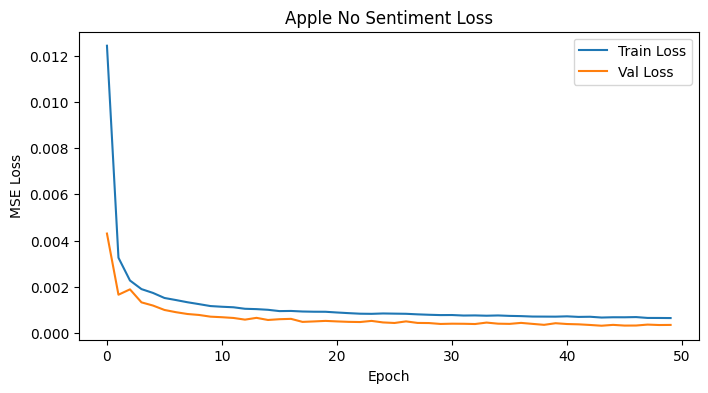

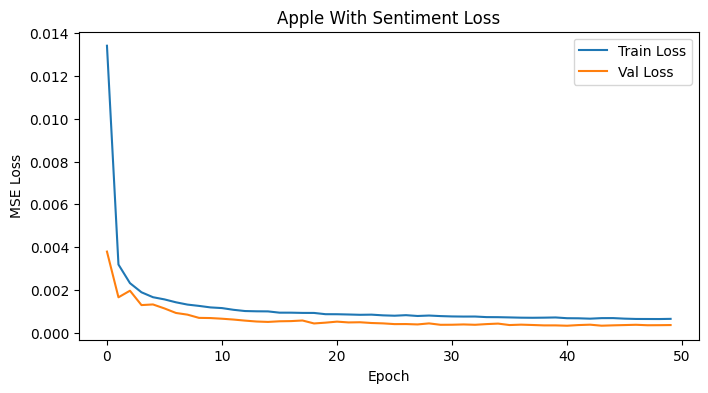

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9

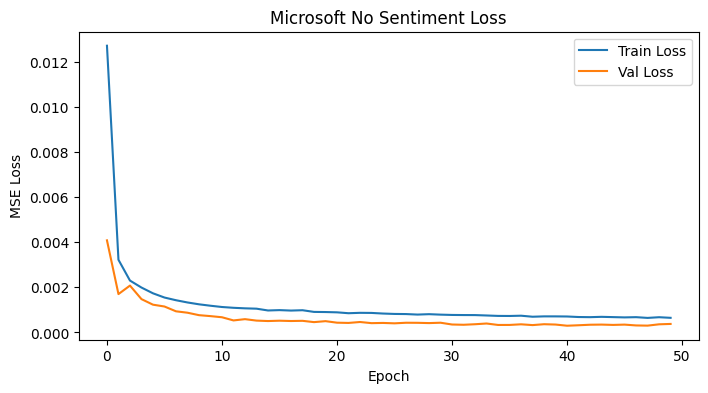

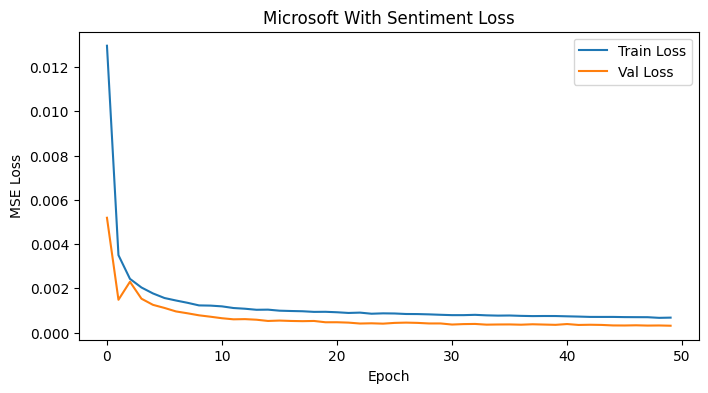


Final Results:
  Company  RMSE (no sentiment)  Accuracy (no sentiment)  \
0    AAPL             0.006889                35.355000   
1    MSFT             0.007408                33.637759   

   RMSE (with sentiment)  Accuracy (with sentiment)  
0               0.007310                  34.205345  
1               0.006569                  34.348793  


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------------------
# 결과 저장 디렉토리 생성
# ------------------------------
os.makedirs("results", exist_ok=True)
results_file_path = "./results/LSTM_results.csv"

# ------------------------------
# 지표 계산 함수
# ------------------------------
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true_adj = np.where(y_true == 0, 0.001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# ------------------------------
# 시각화 함수
# ------------------------------
def plot_metric(df, metric_name, title, ylabel):
    plt.figure(figsize=(10, 6))
    x = df['Company']
    no_sentiment = df[f'{metric_name} (no sentiment)']
    with_sentiment = df[f'{metric_name} (with sentiment)']

    bar_width = 0.35
    index = range(len(x))

    plt.bar(index, no_sentiment, bar_width, label='No Sentiment')
    plt.bar([i + bar_width for i in index], with_sentiment, bar_width, label='With Sentiment')

    plt.xlabel('Company')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks([i + bar_width / 2 for i in index], x)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------
# 시퀀스 생성 함수
# ------------------------------
def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i+seq_size])
        Y.append(data[i+seq_size, target_idx])
    return np.array(X), np.array(Y)

# ------------------------------
# 롤링 윈도우 평가 함수
# ------------------------------
def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=500, test_window=100, threshold=0.05):
    metrics, histories = [], []
    for start in range(0, len(X) - train_window - test_window + 1, test_window):
        X_tr, Y_tr = X[start:start+train_window], Y[start:start+train_window]
        X_te, Y_te = X[start+train_window:start+train_window+test_window], Y[start+train_window:start+train_window+test_window]

        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5))),
            Dropout(0.2),
            LSTM(32, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        def scheduler(epoch, lr): return lr * 0.99
        lr_cb = LearningRateScheduler(scheduler)

        history = model.fit(X_tr, Y_tr,
                            validation_data=(X_te, Y_te),
                            epochs=epochs, batch_size=batch_size,
                            callbacks=[lr_cb],
                            verbose=0)
        histories.append(history.history)

        preds = model.predict(X_te)
        rmse = calculate_rmse(Y_te, preds)
        mae = calculate_mae(Y_te, preds)
        mape = calculate_mape(Y_te, preds)
        accuracy = np.mean(np.abs((Y_te - preds) / np.where(Y_te==0,1e-3,Y_te)) < threshold) * 100
        metrics.append((rmse, mae, mape, accuracy))
    return metrics, histories

# ------------------------------
# 메인 실행
# ------------------------------
results = {'Company': [], 'RMSE (no sentiment)': [], 'MAE (no sentiment)': [], 'MAPE (no sentiment)': [], 'Accuracy (no sentiment)': [],
           'RMSE (with sentiment)': [], 'MAE (with sentiment)': [], 'MAPE (with sentiment)': [], 'Accuracy (with sentiment)': []}
target_idx = 3  # 'Close'

for name, ticker in {"Apple":"AAPL","Microsoft":"MSFT"}.items():
    df = yf.download(ticker, start="2000-01-01", end="2025-03-01", progress=False)
    df.reset_index(inplace=True)
    df = df[['Date','Open','High','Low','Close','Volume']].ffill()

    # No sentiment
    data_no = df.iloc[:,1:].values.astype(float)
    scaled_no = MinMaxScaler().fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size=10, target_idx=target_idx)
    metrics_no, hist_no = rolling_window_evaluation(X_no, Y_no, seq_size=10, columns=df.columns[1:])
    rmse_no = np.mean([m[0] for m in metrics_no])
    mae_no = np.mean([m[1] for m in metrics_no])
    mape_no = np.mean([m[2] for m in metrics_no])
    acc_no = np.mean([m[3] for m in metrics_no])

    # With sentiment (0)
    df_with = df.copy(); df_with['Sentiment'] = 0.0
    data_with = df_with.iloc[:,1:].values.astype(float)
    scaled_with = MinMaxScaler().fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size=10, target_idx=target_idx)
    metrics_with, hist_with = rolling_window_evaluation(X_with, Y_with, seq_size=10, columns=df_with.columns[1:])
    rmse_with = np.mean([m[0] for m in metrics_with])
    mae_with = np.mean([m[1] for m in metrics_with])
    mape_with = np.mean([m[2] for m in metrics_with])
    acc_with = np.mean([m[3] for m in metrics_with])

    print(f"{name}: NoSent RMSE={rmse_no:.4f}, MAE={mae_no:.4f}, MAPE={mape_no:.2f}%, Acc={acc_no:.2f}% | WithSent RMSE={rmse_with:.4f}, MAE={mae_with:.4f}, MAPE={mape_with:.2f}%, Acc={acc_with:.2f}%")

    results['Company'].append(ticker)
    results['RMSE (no sentiment)'].append(rmse_no)
    results['MAE (no sentiment)'].append(mae_no)
    results['MAPE (no sentiment)'].append(mape_no)
    results['Accuracy (no sentiment)'].append(acc_no)
    results['RMSE (with sentiment)'].append(rmse_with)
    results['MAE (with sentiment)'].append(mae_with)
    results['MAPE (with sentiment)'].append(mape_with)
    results['Accuracy (with sentiment)'].append(acc_with)

    # 평균 Loss 시각화
    def plot_avg_loss(histories, title):
        max_ep = max(len(h['loss']) for h in histories)
        avg_train, avg_val = [], []
        for i in range(max_ep):
            train_vals = [h['loss'][i] for h in histories if len(h['loss'])>i]
            val_vals   = [h['val_loss'][i] for h in histories if len(h['val_loss'])>i]
            avg_train.append(np.mean(train_vals)); avg_val.append(np.mean(val_vals))
        plt.figure(figsize=(8,4))
        plt.plot(avg_train, label='Train Loss'); plt.plot(avg_val, label='Val Loss')
        plt.title(title); plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.legend(); plt.show()

    plot_avg_loss(hist_no, f"{name} No Sentiment Loss")
    plot_avg_loss(hist_with, f"{name} With Sentiment Loss")

# 최종 결과 저장 및 시각화

df_results = pd.DataFrame(results)
df_results.to_csv(results_file_path, index=False)

# 막대그래프 시각화
plot_metric(df_results, "RMSE", "RMSE Comparison by Company", "RMSE")
plot_metric(df_results, "MAE", "MAE Comparison by Company", "MAE")
plot_metric(df_results, "MAPE", "MAPE Comparison by Company", "MAPE (%)")
plot_metric(df_results, "Accuracy", "Accuracy (\u00b15%) Comparison by Company", "Accuracy (%)")

print("\nFinal Results:")
print(df_results)

## 코드3 + Meaningful Sentiment(VIX)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━

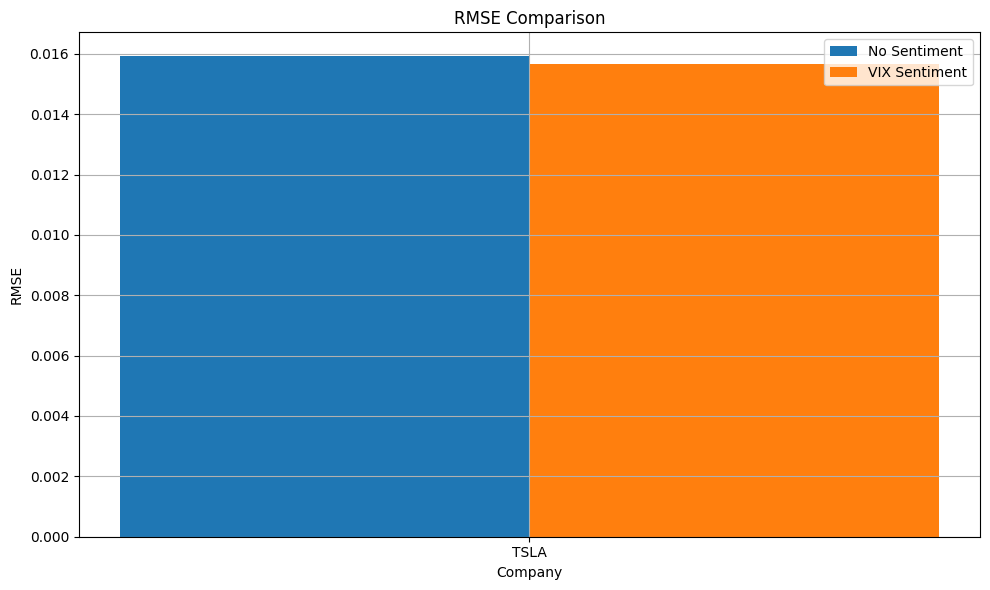

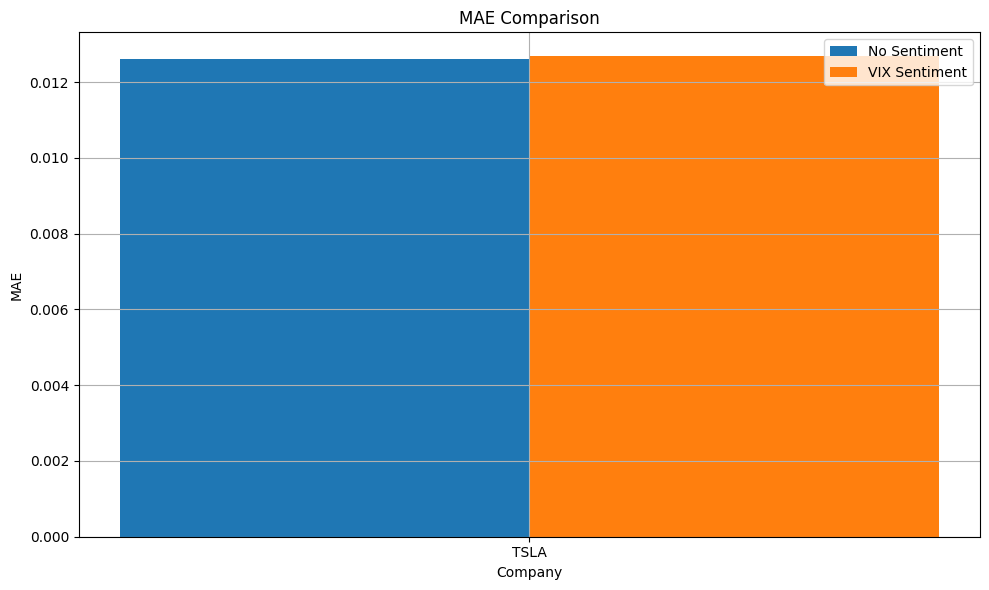

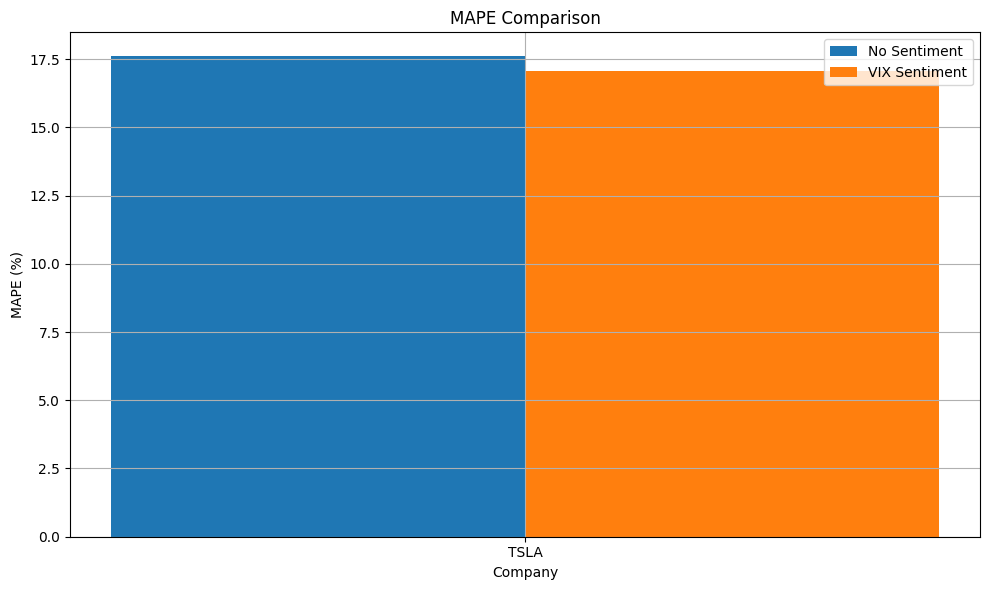

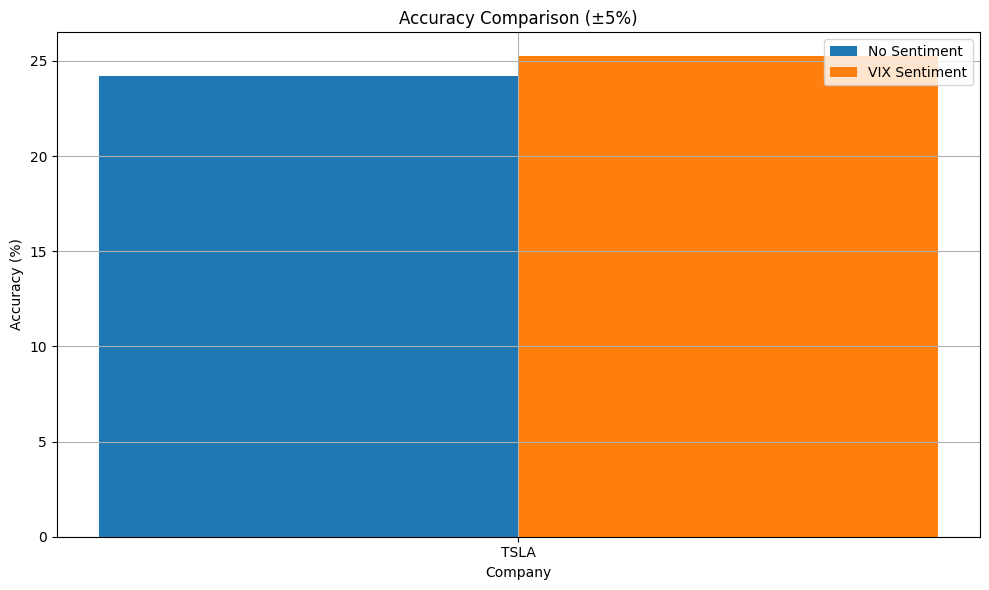


Final Results:
  Company  RMSE (no sentiment)  MAE (no sentiment)  MAPE (no sentiment)  \
0    TSLA             0.015916            0.012626            17.598433   

   Accuracy (no sentiment)  RMSE (with sentiment)  MAE (with sentiment)  \
0                24.205161               0.015675              0.012684   

   MAPE (with sentiment)  Accuracy (with sentiment)  
0              17.046696                  25.237097  


In [10]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------------------
os.makedirs("results", exist_ok=True)
results_file_path = "./results/LSTM_results_vix_sentiment.csv"

# ------------------------------
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true_adj = np.where(y_true == 0, 0.001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_adj)) * 100

# ------------------------------
def create_dataset(dataset, seq_size, target_index):
    X, Y = [], []
    for i in range(len(dataset) - seq_size - 1):
        X.append(dataset[i:(i + seq_size)])
        Y.append(dataset[i + seq_size, target_index])
    return np.array(X), np.array(Y)

# ------------------------------
def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=500, test_window=100, threshold=0.05):
    total_samples = len(X)
    metrics_list = []

    for start in range(0, total_samples - train_window - test_window + 1, test_window):
        X_train = X[start: start + train_window]
        Y_train = Y[start: start + train_window]
        X_test  = X[start + train_window: start + train_window + test_window]
        Y_test  = Y[start + train_window: start + train_window + test_window]

        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        def scheduler(epoch, lr): return lr * 0.99
        callback = LearningRateScheduler(scheduler)

        model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                  epochs=epochs, batch_size=batch_size, callbacks=[callback], verbose=0)

        predictions = model.predict(X_test)
        rmse = calculate_rmse(Y_test, predictions)
        mae = calculate_mae(Y_test, predictions)
        mape = calculate_mape(Y_test, predictions)
        relative_errors = np.abs((Y_test - predictions) / np.where(Y_test == 0, 0.001, Y_test))
        accuracy = np.mean(relative_errors < threshold) * 100

        metrics_list.append((rmse, mae, mape, accuracy))

    return metrics_list

# ------------------------------
results = {
    'Company': [],
    'RMSE (no sentiment)': [], 'MAE (no sentiment)': [], 'MAPE (no sentiment)': [], 'Accuracy (no sentiment)': [],
    'RMSE (with sentiment)': [], 'MAE (with sentiment)': [], 'MAPE (with sentiment)': [], 'Accuracy (with sentiment)': []
}

stock_dict = {"Tesla": "TSLA"}
start_date = "2000-01-01"
end_date = "2025-03-01"
seq_size = 10
target_index = 3

# ------------------------------
# Load VIX
vix_df = yf.download("^VIX", start=start_date, end=end_date, progress=False)[['Close']]
vix_df.rename(columns={'Close': 'VIX'}, inplace=True)
vix_df.ffill(inplace=True)

# ------------------------------
for company_name, ticker in stock_dict.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    df.reset_index(inplace=True)
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].ffill()

    # No Sentiment
    df_no = df.copy()
    cols_no = df_no.columns[1:]
    data_no = df_no[cols_no].values.astype(float)
    scaled_no = MinMaxScaler().fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size, target_index)
    metrics_no = rolling_window_evaluation(X_no, Y_no, seq_size, cols_no)
    rmse_no = np.mean([m[0] for m in metrics_no])
    mae_no = np.mean([m[1] for m in metrics_no])
    mape_no = np.mean([m[2] for m in metrics_no])
    acc_no = np.mean([m[3] for m in metrics_no])

    # With Sentiment = VIX
    df_with = df.copy()
    df_with = df_with.merge(vix_df, on="Date", how="left")
    df_with.rename(columns={"VIX": "Sentiment"}, inplace=True)
    df_with.ffill(inplace=True)
    cols_with = df_with.columns[1:]
    data_with = df_with[cols_with].values.astype(float)
    scaled_with = MinMaxScaler().fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size, target_index)
    metrics_with = rolling_window_evaluation(X_with, Y_with, seq_size, cols_with)
    rmse_with = np.mean([m[0] for m in metrics_with])
    mae_with = np.mean([m[1] for m in metrics_with])
    mape_with = np.mean([m[2] for m in metrics_with])
    acc_with = np.mean([m[3] for m in metrics_with])

    print(f"{company_name}: NoSent RMSE={rmse_no:.4f}, MAE={mae_no:.4f}, MAPE={mape_no:.2f}%, Acc={acc_no:.2f}% | "
          f"VIXSent RMSE={rmse_with:.4f}, MAE={mae_with:.4f}, MAPE={mape_with:.2f}%, Acc={acc_with:.2f}%")

    results['Company'].append(ticker)
    results['RMSE (no sentiment)'].append(rmse_no)
    results['MAE (no sentiment)'].append(mae_no)
    results['MAPE (no sentiment)'].append(mape_no)
    results['Accuracy (no sentiment)'].append(acc_no)
    results['RMSE (with sentiment)'].append(rmse_with)
    results['MAE (with sentiment)'].append(mae_with)
    results['MAPE (with sentiment)'].append(mape_with)
    results['Accuracy (with sentiment)'].append(acc_with)

# ------------------------------
df_results = pd.DataFrame(results)
df_results.to_csv(results_file_path, index=False)

# ------------------------------
def plot_metric(metric_name, title, ylabel):
    plt.figure(figsize=(10, 6))
    x = df_results['Company']
    no_sent = df_results[f'{metric_name} (no sentiment)']
    with_sent = df_results[f'{metric_name} (with sentiment)']

    bar_width = 0.35
    index = range(len(x))

    plt.bar(index, no_sent, bar_width, label='No Sentiment')
    plt.bar([i + bar_width for i in index], with_sent, bar_width, label='VIX Sentiment')

    plt.xlabel('Company')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks([i + bar_width / 2 for i in index], x)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------
plot_metric("RMSE", "RMSE Comparison", "RMSE")
plot_metric("MAE", "MAE Comparison", "MAE")
plot_metric("MAPE", "MAPE Comparison", "MAPE (%)")
plot_metric("Accuracy", "Accuracy Comparison (±5%)", "Accuracy (%)")

print("\nFinal Results:")
print(df_results)

YF.download() has changed argument auto_adjust default to True
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x371f5bec0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s

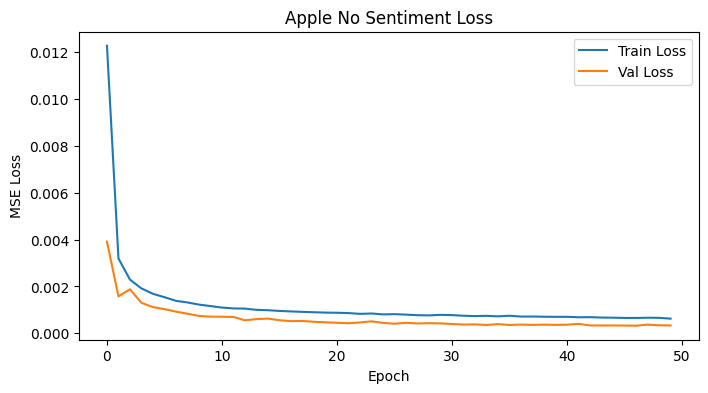

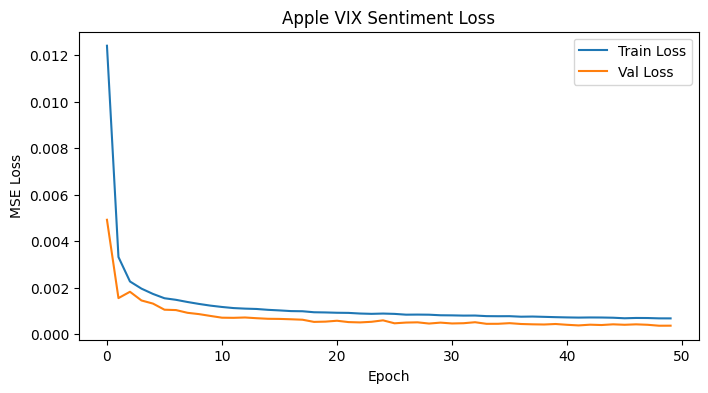

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━

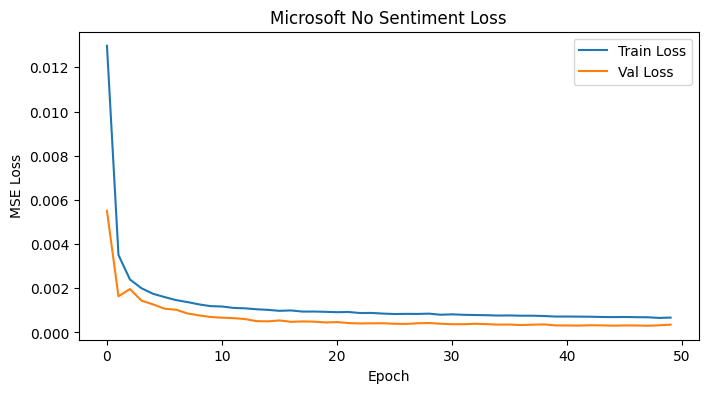

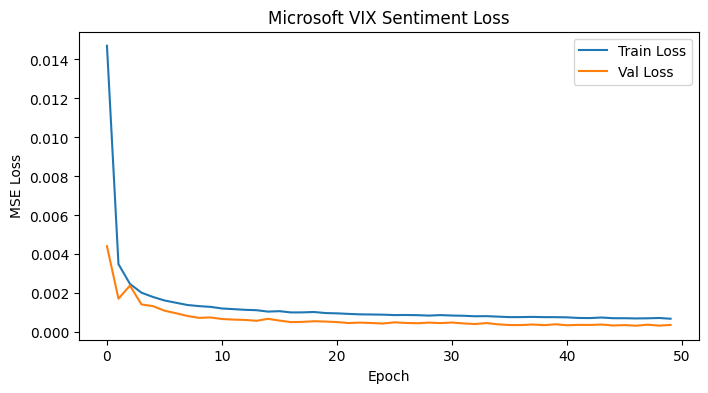


Final Results:
  Company  RMSE (no sentiment)  Accuracy (no sentiment)  \
0    AAPL             0.007141                33.996207   
1    MSFT             0.007263                33.868276   

   RMSE (with sentiment)  Accuracy (with sentiment)  
0               0.007216                  31.056379  
1               0.007331                  32.596724  


In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

os.makedirs("results", exist_ok=True)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def create_dataset(data, seq_size, target_idx):
    X, Y = [], []
    for i in range(len(data) - seq_size - 1):
        X.append(data[i:i+seq_size])
        Y.append(data[i+seq_size, target_idx])
    return np.array(X), np.array(Y)

def rolling_window_evaluation(X, Y, seq_size, columns, epochs=50, batch_size=32,
                              train_window=500, test_window=100, threshold=0.05):
    metrics, histories = [], []
    for start in range(0, len(X) - train_window - test_window + 1, test_window):
        X_tr, Y_tr = X[start:start+train_window], Y[start:start+train_window]
        X_te, Y_te = X[start+train_window:start+train_window+test_window], Y[start+train_window:start+train_window+test_window]

        model = Sequential([
            Input(shape=(seq_size, len(columns))),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5))),
            Dropout(0.2),
            LSTM(32, kernel_regularizer=l2(1e-5)),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        history = model.fit(X_tr, Y_tr,
                            validation_data=(X_te, Y_te),
                            epochs=epochs, batch_size=batch_size,
                            callbacks=[LearningRateScheduler(lambda e,lr:lr*0.99)],
                            verbose=0)
        histories.append(history.history)

        preds = model.predict(X_te)
        rmse = calculate_rmse(Y_te, preds)
        accuracy = np.mean(np.abs((Y_te - preds) / np.where(Y_te==0,1e-3,Y_te)) < threshold) * 100
        metrics.append((rmse, accuracy))
    return metrics, histories

results = {'Company': [], 'RMSE (no sentiment)': [], 'Accuracy (no sentiment)': [],
           'RMSE (with sentiment)': [], 'Accuracy (with sentiment)': []}
target_idx = 3  # Close

# VIX 데이터 미리 로드
vix_df = yf.download("^VIX", start="2000-01-01", end="2025-03-01", progress=False)[['Close']]
vix_df = vix_df.rename(columns={'Close':'VIX'}).ffill()

for name, ticker in {"Apple":"AAPL","Microsoft":"MSFT"}.items():
    df = yf.download(ticker, start="2000-01-01", end="2025-03-01", progress=False)
    df.reset_index(inplace=True)
    df = df[['Date','Open','High','Low','Close','Volume']].ffill()

    # No sentiment
    data_no = df.iloc[:,1:].values.astype(float)
    scaled_no = MinMaxScaler().fit_transform(data_no)
    X_no, Y_no = create_dataset(scaled_no, seq_size=10, target_idx=target_idx)
    metrics_no, hist_no = rolling_window_evaluation(X_no, Y_no, seq_size=10, columns=df.columns[1:])
    rmse_no = np.mean([m[0] for m in metrics_no])
    acc_no = np.mean([m[1] for m in metrics_no])

    # With VIX sentiment
    df_with = df.copy().set_index('Date').join(vix_df, how='left').ffill()
    data_with = df_with.values.astype(float)
    scaled_with = MinMaxScaler().fit_transform(data_with)
    X_with, Y_with = create_dataset(scaled_with, seq_size=10, target_idx=target_idx)
    metrics_with, hist_with = rolling_window_evaluation(
        X_with, Y_with, seq_size=10, columns=df_with.columns)
    rmse_with = np.mean([m[0] for m in metrics_with])
    acc_with = np.mean([m[1] for m in metrics_with])

    print(f"{name}: NoSent RMSE={rmse_no:.4f}, Acc={acc_no:.2f}% | VIXSent RMSE={rmse_with:.4f}, Acc={acc_with:.2f}%")

    results['Company'].append(ticker)
    results['RMSE (no sentiment)'].append(rmse_no)
    results['Accuracy (no sentiment)'].append(acc_no)
    results['RMSE (with sentiment)'].append(rmse_with)
    results['Accuracy (with sentiment)'].append(acc_with)

    # 평균 Loss 시각화
    def plot_avg_loss(histories, title):
        max_ep = max(len(h['loss']) for h in histories)
        avg_train, avg_val = [], []
        for i in range(max_ep):
            train_vals = [h['loss'][i] for h in histories if len(h['loss'])>i]
            val_vals   = [h['val_loss'][i] for h in histories if len(h['val_loss'])>i]
            avg_train.append(np.mean(train_vals))
            avg_val.append(np.mean(val_vals))
        plt.figure(figsize=(8,4))
        plt.plot(avg_train, label='Train Loss')
        plt.plot(avg_val, label='Val Loss')
        plt.title(title); plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.legend(); plt.show()

    plot_avg_loss(hist_no, f"{name} No Sentiment Loss")
    plot_avg_loss(hist_with, f"{name} VIX Sentiment Loss")

df_results = pd.DataFrame(results)
df_results.to_csv("./results/LSTM_results_vix.csv", index=False)
print("\nFinal Results:")
print(df_results)